In [151]:
from graphdatascience import GraphDataScience
import pandas as pd
import umap
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from getpass import getpass
from sentence_transformers import SentenceTransformer
from langdetect import detect, LangDetectException

# Demonstrate embeddings on some test sentences

In [152]:
test_sentences = pd.DataFrame( 
    [["I like to play Minecraft.", "en"],
      ["J'aime jouer à Minecraft.", "fr"],
      ["Jag gillar att spela Minecraft.", "se"],
      ["Neo4j is a graph database.", "en"],
      ["Neo4j est une base de données graphique.", "fr"],
      ["Neo4j är en grafdatabase.", "se"]], columns=["sentence", "language"])


In [153]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [154]:
test_embeddings = model.encode((test_sentences['sentence'].to_list()))

In [155]:
reducer = umap.UMAP(n_components=2)
embedding_reduced = reducer.fit_transform(test_embeddings)

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/umap/umap_.py:2437: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [156]:
test_umap_df = pd.DataFrame(embedding_reduced, columns=['umap1', 'umap2'])
test_sentences = pd.concat([test_sentences, test_umap_df], axis=1)

In [157]:
fig = px.scatter(test_sentences, x='umap1', y='umap2', color='language', text=test_sentences['sentence'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.update_traces(
        marker=dict(size=20),  # Increase point size
        textposition='top center'  # Position of the text labels
    )   
fig.show()

# Connect to Neo4j

In [158]:
bolt_url = "bolt://3.95.218.232:7687"

In [159]:
gds = GraphDataScience(bolt_url, auth=("neo4j", getpass("Neo4j password")))

# Create embeddings for streamer descriptions

In [234]:
descriptions_df = gds.run_cypher("MATCH (s:Stream) WHERE s.description IS NOT NULL and size(s.description) > 1 RETURN id(s) AS nodeId, s.description AS description")

In [235]:
descriptions_df.head(25)

,nodeId,description
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin..."
1,3,I'm a variety streamer(kind of). Been streamin...
2,5,感謝します。
3,8,Топовая студия в мире профессионального киберс...
4,11,Maximilian's Livestream Of Hype! Modern fighti...
5,14,楽しんでゲームしていきます
6,15,spawns at midnight (pst)
7,16,On se tape des immenses barres.
8,19,Welcome to my stream! My name is Amouranth and...
9,21,Yes | Epic Gamer | Content Creator for Luminos...


In [236]:
description_embeddings = model.encode(descriptions_df['description'].to_list())

In [237]:
descriptions_df['description_embedding'] = description_embeddings.tolist()

# Detect the language of the descriptions

In [238]:
def detect_language(text):
    try:
        language = detect(text)
        return language
    except LangDetectException:
        return "Uknown"

In [239]:
descriptions_df['language'] = descriptions_df['description'].map(detect_language)

In [240]:
descriptions_df.head()

,nodeId,description,description_embedding,language
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin...","[0.041167739778757095, 0.015329542569816113, -...",en
1,3,I'm a variety streamer(kind of). Been streamin...,"[0.03127303346991539, 0.02153877355158329, -0....",en
2,5,感謝します。,"[0.04786687344312668, -0.02418091520667076, -0...",ja
3,8,Топовая студия в мире профессионального киберс...,"[-0.008097570389509201, 0.00705909077078104, -...",ru
4,11,Maximilian's Livestream Of Hype! Modern fighti...,"[-0.06260043382644653, 0.008335482329130173, -...",en


In [241]:
descriptions_df['language'].value_counts()

language
en        1737
es         300
ko         235
de         227
fr         211
pt         188
ru         170
it         143
tr         106
pl          63
ja          45
Uknown      38
nl          36
so          28
fi          25
tl          24
ca          23
hu          23
id          23
th          22
no          22
da          21
cs          16
et          15
cy          15
zh-tw       14
sw          14
ar          14
ro          13
sk          11
af          11
vi           9
bg           9
hr           8
uk           8
sv           7
sl           6
zh-cn        5
mk           4
lt           3
lv           3
sq           3
el           1
fa           1
Name: count, dtype: int64

# Upload results to Neo4j

In [242]:
gds.run_cypher("""
UNWIND $data AS row
MATCH (n) WHERE id(n) = row['nodeId']
SET n.language = row['language']
WITH n, row
CALL db.create.setNodeVectorProperty(n, "descriptionEmbedding", row['description_embedding'])
               """, {"data": descriptions_df.to_dict('records')})

""


# Create graph projection
Using native projection because of bug in Cypher projection that prevents projection float arrays as properties. There is already a fix for this, but it hasn't been roled out to sandboxes yet.

In [243]:
gds.run_cypher("""MATCH (s:Stream) WHERE s.descriptionEmbedding IS NOT NULL SET s:StreamEmbedding""")

""


In [244]:
gds.graph.drop("descriptions_all")

g_descriptions_all, result = gds.graph.project(
    "descriptions_all",
    ["StreamEmbedding"],
    {"HAS_SIMILAR_INTERACTORS":
        {"orientation": "UNDIRECTED",
        "properties": "similarity"}},
    nodeProperties=["descriptionEmbedding"])
result

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

nodeProjection            {'StreamEmbedding': {'label': 'StreamEmbedding...
relationshipProjection    {'HAS_SIMILAR_INTERACTORS': {'aggregation': 'D...
graphName                                                  descriptions_all
nodeCount                                                              3900
relationshipCount                                                     50204
projectMillis                                                           710
Name: 0, dtype: object

In [245]:

gds.graph.drop("descriptions")
g_descriptions, result = gds.graph.filter("descriptions",
                                          g_descriptions_all,
                                          "degree() > 0",
                                          "*" )
result

fromGraphName         descriptions_all
nodeFilter                degree() > 0
relationshipFilter                   *
graphName                 descriptions
nodeCount                         3777
relationshipCount                50204
projectMillis                      327
Name: 0, dtype: object

In [246]:
gds.graph.drop(g_descriptions_all)

graphName                                                 descriptions_all
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             3900
relationshipCount                                                    50204
configuration            {'relationshipProjection': {'HAS_SIMILAR_INTER...
density                                                           0.003302
creationTime                           2024-10-03T13:52:48.769305557+00:00
modificationTime                       2024-10-03T13:52:48.769305557+00:00
schema                   {'graphProperties': {}, 'nodes': {'StreamEmbed...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'StreamEmbed...
Name: 0, dtype: object

# Run fastRP with and without properties

In [247]:
gds.fastRP.write(g_descriptions, 
                 propertyRatio = 1.0,
                 featureProperties = ["descriptionEmbedding"],
                 embeddingDimension = 256,
                 iterationWeights = [0.0, 1.0, 1.0],
                 randomSeed = 24,                               
                 relationshipWeightProperty = "similarity",
                 writeProperty = "fastRPDescriptionEmbedding")

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

nodeCount                                                             3777
nodePropertiesWritten                                                 3777
preProcessingMillis                                                      0
computeMillis                                                          695
writeMillis                                                             58
configuration            {'writeProperty': 'fastRPDescriptionEmbedding'...
Name: 0, dtype: object

In [248]:
fastRP_description_df = gds.run_cypher("MATCH (s:Stream) WHERE s.fastRPDescriptionEmbedding IS NOT NULL RETURN id(s) AS nodeId, s.fastRPDescriptionEmbedding AS fastRP_description_embedding")

In [249]:
descriptions_df = descriptions_df.merge(fastRP_description_df, on="nodeId")

In [250]:
gds.fastRP.write(g_descriptions, 
                               embeddingDimension = 256,
                               iterationWeights = [0.0, 1.0, 1.0],
                               randomSeed = 24,                               
                               relationshipWeightProperty = "similarity",
                               writeProperty="fastRPNoDescriptionEmbedding")

nodeCount                                                             3777
nodePropertiesWritten                                                 3777
preProcessingMillis                                                      0
computeMillis                                                          463
writeMillis                                                             60
configuration            {'writeProperty': 'fastRPNoDescriptionEmbeddin...
Name: 0, dtype: object

In [251]:
fastRP_no_props_df = gds.run_cypher("MATCH (s:Stream) WHERE s.fastRPNoDescriptionEmbedding IS NOT NULL RETURN id(s) AS nodeId, s.fastRPNoDescriptionEmbedding AS fastRP_no_property_embedding")

In [252]:
descriptions_df = descriptions_df.merge(fastRP_no_props_df, on="nodeId")

# Run WCC
Visualizations will make more sense with isolated nodes excluded.

In [253]:
wcc_df = gds.wcc.stream(g_descriptions)
descriptions_df = descriptions_df.merge(wcc_df, on="nodeId")

In [254]:
descriptions_df.columns

Index(['nodeId', 'description', 'description_embedding', 'language',
       'fastRP_description_embedding', 'fastRP_no_property_embedding',
       'componentId'],
      dtype='object')

# Use UMAP to reduce embeddings to two dimensions for plotting

In [219]:
description_embedding_reduced = reducer.fit_transform(np.array(list(descriptions_df['description_embedding'])))
description_umap_df = pd.DataFrame(description_embedding_reduced, columns=['description_umap1', 'description_umap2'])
descriptions_df = pd.concat([descriptions_df, description_umap_df], axis=1)

In [220]:
fastrp_property_reduced = reducer.fit_transform(np.array(list(descriptions_df['fastRP_description_embedding'])))
fastRP_prop_umap_df = pd.DataFrame(fastrp_property_reduced, columns=['fastRP_description_umap1', 'fastRP_description_umap2'])
descriptions_df = pd.concat([descriptions_df, fastRP_prop_umap_df], axis=1)

In [255]:
fastrp_no_prop_reduced = reducer.fit_transform(np.array(list(descriptions_df['fastRP_no_property_embedding'])))
fastRP_no_prop_umap_df = pd.DataFrame(fastrp_no_prop_reduced, columns=['fastRP_no_property_umap1', 'fastRP_no_property_umap2'])
descriptions_df = pd.concat([descriptions_df, fastRP_no_prop_umap_df], axis=1)

In [256]:
descriptions_df.head()

,nodeId,description,description_embedding,language,fastRP_description_embedding,fastRP_no_property_embedding,componentId,fastRP_no_property_umap1,fastRP_no_property_umap2
0,0,"Welcome to my Channel, I'm Big Chase, 31 livin...","[0.041167739778757095, 0.015329542569816113, -...",en,"[-0.12720730900764465, -0.01800876297056675, -...","[-0.16644741594791412, -0.24395161867141724, 0...",0,12.033944,-3.543244
1,3,I'm a variety streamer(kind of). Been streamin...,"[0.03127303346991539, 0.02153877355158329, -0....",en,"[-0.03292136639356613, 0.1149466335773468, 0.0...","[-0.002396106719970703, -0.0728759840130806, 0...",0,8.146853,7.145399
2,5,感謝します。,"[0.04786687344312668, -0.02418091520667076, -0...",ja,"[-0.08226659893989563, 0.037958621978759766, 0...","[0.01177993230521679, -0.025558916851878166, -...",0,9.056554,7.716873
3,8,Топовая студия в мире профессионального киберс...,"[-0.008097570389509201, 0.00705909077078104, -...",ru,"[-0.02688448317348957, 0.007026664912700653, 0...","[0.11161065846681595, -0.008263392373919487, 0...",0,7.690250,9.429608
4,11,Maximilian's Livestream Of Hype! Modern fighti...,"[-0.06260043382644653, 0.008335482329130173, -...",en,"[-0.06412945687770844, 0.10144606232643127, 0....","[-0.037699367851018906, -0.07377389073371887, ...",0,8.195901,7.230085


# Visualize embeddings

In [257]:
fig = px.scatter(descriptions_df, x='description_umap1', y='description_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['nodeId', 'description', 'description_embedding', 'language', 'fastRP_description_embedding', 'fastRP_no_property_embedding', 'componentId', 'fastRP_no_property_umap1', 'fastRP_no_property_umap2'] but received: description_umap1

In [136]:
fig = px.scatter(descriptions_df[descriptions_df['componentId']==0], x='fastRP_description_umap1', y='fastRP_description_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

In [137]:
fig = px.scatter(descriptions_df[descriptions_df['componentId']==0], x='fastRP_no_property_umap1', y='fastRP_no_property_umap2', color='language', hover_data=['description', 'nodeId'], width=900, height=900)
fig.update_layout(
    yaxis={"scaleanchor":"x", "scaleratio":1}
)
fig.show()

# Create vector indexes for embeddings 

In [258]:
gds.run_cypher("""
               CREATE VECTOR INDEX descriptionEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.descriptionEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 512,
               `vector.similarity_function`: 'COSINE'}}""")

""


In [259]:
gds.run_cypher("""
               CREATE VECTOR INDEX fastRPNoDescriptionEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.fastRPNoDescriptionEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 256,
               `vector.similarity_function`: 'COSINE'}}""")

""


In [260]:
gds.run_cypher("""
               CREATE VECTOR INDEX fastRPDescriptionEmbedding IF NOT EXISTS 
               FOR (n:Stream) ON (n.fastRPDescriptionEmbedding) 
               OPTIONS {indexConfig: 
                {`vector.dimensions`: 256,
               `vector.similarity_function`: 'COSINE'}}""")

""


# Find the five most similar nodes for each streamer based on embeddings 
Find out if the neighbors are within 2 hops of the streamer, the cosine similarity score for the description embeddings, and whether the languages match

In [261]:
prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPDescriptionEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("fastRPDescriptionEmbedding", 6, s.fastRPDescriptionEmbedding) 
YIELD node, score
WHERE node <> s
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch""")

In [267]:
no_prop_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoDescriptionEmbedding IS NOT NULL
AND s.descriptionEmbedding IS NOT NULL
WITH s
CALL db.index.vector.queryNodes("fastRPNoDescriptionEmbedding", 6, s.fastRPNoDescriptionEmbedding) 
YIELD node, score
WHERE node <> s
AND node.descriptionEmbedding IS NOT NULL
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch""")

In [272]:
description_neighbors_df = gds.run_cypher("""
MATCH (s:Stream)
WHERE s.fastRPNoDescriptionEmbedding IS NOT NULL
AND s.fastRPDescriptionEmbedding IS NOT NULL
AND s.descriptionEmbedding IS NOT NULL                                          
WITH s
CALL db.index.vector.queryNodes("descriptionEmbedding", 6, s.descriptionEmbedding) 
YIELD node, score
WHERE node <> s
AND node.descriptionEmbedding IS NOT NULL
AND node.fastRPNoDescriptionEmbedding IS NOT NULL  
AND node.fastRPDescriptionEmbedding IS NOT NULL                                      
RETURN
CASE WHEN EXISTS { (s)-[:HAS_SIMILAR_INTERACTORS]-{1,2}(node)} THEN 1 ELSE 0 END AS pathCount, 
gds.similarity.cosine(s.descriptionEmbedding, node.descriptionEmbedding) AS descriptionSim,
CASE WHEN s.language = node.language THEN 1 ELSE 0 END AS languageMatch,
gds.similarity.cosine(s.fastRPDescriptionEmbedding, node.fastRPDescriptionEmbedding) AS fastRPPropertySim,
gds.similarity.cosine(s.fastRPNoDescriptionEmbedding, node.fastRPNoDescriptionEmbedding) AS fastRPNoPropertySim
                                          """)

# Check stats for the different sets of neighbors

In [273]:
prop_neighbors_df.apply('mean')

pathCount         0.777041
descriptionSim    0.158563
languageMatch     0.412517
dtype: float64

In [274]:
no_prop_neighbors_df.apply('mean')

pathCount         0.896296
descriptionSim    0.147305
languageMatch     0.454221
dtype: float64

In [275]:
description_neighbors_df.apply('mean')

pathCount              0.092523
descriptionSim         0.545566
languageMatch          0.332951
fastRPPropertySim      0.646422
fastRPNoPropertySim    0.079620
dtype: float64

Two nodes that are close in the feature space will be closer in the property based embedding space than the non-property-based embedding space.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



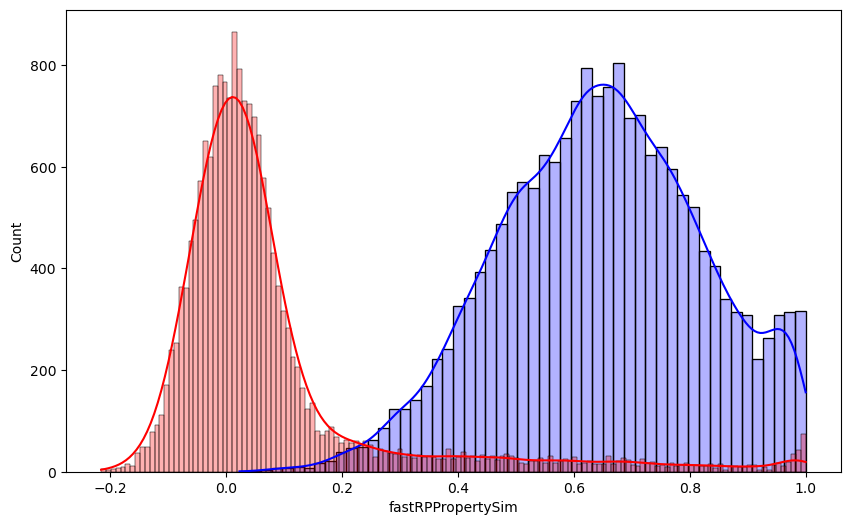

In [276]:
plt.figure(figsize=(10, 6))

sns.histplot(data=description_neighbors_df, x='fastRPPropertySim', kde=True, color='blue', alpha=0.3, label='FastRP with properties')
sns.histplot(data=description_neighbors_df, x='fastRPNoPropertySim', kde=True, color='red', alpha=0.3, label='FastRP without properties')

plt.show()

Similar property-based embeddings does not imply that two nodes are a lot closer together in the input feature space than similar non-property based embeddings.

* The node embedding is based on an aggregation of features of all the nodes in the neighborhood, not just the node that gets the embedding.
* If the neighborhood nodes' features are not very similar to the target node, it is less likely that neighbors close in the embedding space will have similar feature vectors


/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/nathansmith/anaconda3/envs/neo4j/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



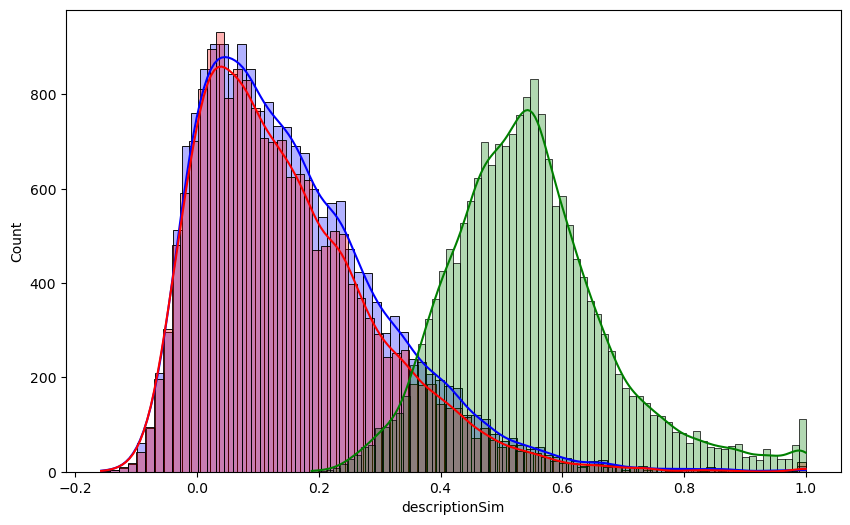

In [277]:
plt.figure(figsize=(10, 6))

sns.histplot(data=prop_neighbors_df, x='descriptionSim', kde=True, color='blue', alpha=0.3, label='FastRP with properties')
sns.histplot(data=no_prop_neighbors_df, x='descriptionSim', kde=True, color='red', alpha=0.3, label='FastRP without properties')
sns.histplot(data=description_neighbors_df, x='descriptionSim', kde=True, color='green', alpha=0.3, label='Description embeddings')

plt.show()

Find the median embedding similarity for `Stream` nodes that share a `HAS_SIMILAR_INTERACTORS` relationship.

In [278]:
gds.run_cypher("""
MATCH (s1:Stream)-[:HAS_SIMILAR_INTERACTORS]->(s2)
WHERE s1.descriptionEmbedding IS NOT NULL
AND s2.descriptionEmbedding IS NOT NULL
RETURN percentileCont(gds.similarity.cosine(s1.descriptionEmbedding, s2.descriptionEmbedding), 0.5) AS medianEmbeddingSimilarity
""")

,medianEmbeddingSimilarity
0,0.126048


In [279]:
gds.graph.drop(g_descriptions)

graphName                                                     descriptions
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             3777
relationshipCount                                                    50204
configuration            {'relationshipProperties': {}, 'jobId': 'bd5b4...
density                                                            0.00352
creationTime                           2024-10-03T13:52:49.309349069+00:00
modificationTime                       2024-10-03T13:52:49.309349069+00:00
schema                   {'graphProperties': {}, 'nodes': {'StreamEmbed...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'StreamEmbed...
Name: 0, dtype: object

In [ ]:
s